The first part of the code initializes the database that you will need for the last part of the assignment. It also adds some libraries to help with handling your code. If you wish to use more libraries you can add them here. When prompted, you will get a request to allow Google SDK access your google account. Follow the link and accept with your university google account. Copy the verification link. You should see a plot of the PES of H2 if everything was successful.

In [ ]:
%pip install netCDF4 
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import math

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1AX7p4iDbbXSV9af5kXw9szzoDJ13IRcF/view?usp=sharing'
id ='1AX7p4iDbbXSV9af5kXw9szzoDJ13IRcF'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('testdata.nc') 
testdata = 'testdata.nc' 
ds = nc.Dataset(testdata)

for var in ds.variables.values():
    print(var)

yAxis = []
xAxis = np.arange(0.25,5.05,0.05)
for i in range(96):
  yAxis.append(ds['energy'][i][0:])
  
plt.ylabel("Ev")
plt.xlabel("Bond Distance")
plt.plot(xAxis,yAxis)
plt.savefig('test_data.png')

Here we create the training data for the first part of the assignment. The input array will be the input of your network, and you will train the network to predict the output that fits to its respective input. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle

np.set_printoptions(precision=3,suppress=True)

input_array = np.array([[0,0,1],[1,0,1,],[0,1,1],[1,1,1]])
output_array = np.array([[0],[1],[1],[0]])

sig =  lambda x: 1 / (1 + np.exp(-x))
dsig = lambda x: x * ( 1 - x )

Text(7, 0.3, '$\\frac{1}{1+e^{-x}}$')

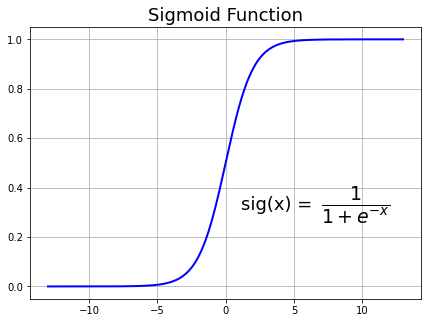

In [ ]:
plt.figure(figsize=(7,5))
plt.title('Sigmoid Function', fontsize=18)
X = np.arange(-13,13,0.02)
plt.plot(X,sig(X),lw=2,c='b')
plt.grid()
plt.text(1.1,0.31,'sig(x) = ',fontsize=18)
plt.text(7,0.3,r'$\frac{1}{1+e^{-x}}$',fontsize=27)

To start, we will initialize the neural network. 

1.  The size of the input and output nodes is given by your training data above.
 
2.  Create a hidden layer with 4 nodes. 

1.  Create a weighted connection between the input and hidden layer nodes
2.  Create a weighted connection between the hidden layer nodes and output nodes








Write a function that transforms the output of a layer with the sigmoid function. Also write a function that generates the derivative of this function. Finally create a learning rate variable to use in updating the network.


With the pieces in place, generate a forward pass of the network. Input each column in the input_array. The network should pass the input to the hidden layers through the weighted connections using the sigmoid function, and from the hidden layers use the connections to reach the ouput node.

Compare the output of your model with each of the training outputs. Subtract the training output from your model output, this is your error. Use this error to calculate the change in the output weights or delta_output. This is calculated by taking the error and multiplying it with the derivative of the output.

Using delta_output, we calculate the change to each of the input layer to hidden layer connections. We multiply delta_output with each of the weighted connections and the derivative of the ouput of each hidden layer. This is the change for each of the input layer to hidden layer weights.

Apply the changes to all of the weights while multipliying them with the learning rate. 




In [ ]:
def batch_learn(in_mtx,out_mtx,nodes,epochs,alpha):
  '''
  This function takes input array and output array as ndarray;
  nodes requires a integer list which represents the number of nodes
  in each hidden layer;
  The output is the prediction and error after each epoch
  as 3d array, and the optimized weights as a list of ndarray.
  '''
  weights = []; hidden = [in_mtx]; w_crr = []
  Predict_li = []; Err_li = []; layers = len(nodes)
  nodes.append(out_mtx.shape[1]); nodes.insert(0,in_mtx.shape[1])

  for i in range(layers+1):
    # initialize Weights
    weights.append(np.random.normal(0,1,(nodes[i],nodes[i+1])))
    hidden.append( np.zeros([in_mtx.shape[0],nodes[i+1]]) )
  for e in range(epochs):
    # Forward Propagation
    for i in range(layers+1):
      hidden[i+1] = sig( hidden[i] @ weights[i] )
    err = hidden[-1] - out_mtx
    Err_li.append(err); Predict_li.append(hidden[-1])
    # Back Propagation
    for i in range(layers+1):
      Delta = err * dsig(hidden[-1-i])
      w_crr.insert(0,hidden[-2-i].T @ Delta * alpha)
      err = Delta @ weights[-1-i].T
    for i in range(layers+1): weights[i] -= w_crr[i]
  
  return np.array(Predict_li),np.array(Err_li),weights

We now repeat this process for 10.000 epochs. Check if the error of the model is decreasing over time and aproaches 0. If this the case the model is working and we can apply to the PES data.

In [ ]:
Hidden_Layer_Nodes = [4]
Epochs = 10000; Learning_rate = 0.5

predict_result,error_result,weights = batch_learn(input_array,output_array,Hidden_Layer_Nodes,Epochs,Learning_rate)

Predict_mtx = predict_result.reshape(predict_result.shape[:2])
Err_mtx = error_result.reshape(error_result.shape[:2])
print('Input:\n',input_array)
print('Output:\n',output_array)
print('Final Prediction:\n',Predict_mtx[-1,:].reshape(4,1))
print('Final Error:\n',Err_mtx[-1,:].reshape(4,1).T)

Input:
 [[0 0 1]
 [1 0 1]
 [0 1 1]
 [1 1 1]]
Output:
 [[0]
 [1]
 [1]
 [0]]
Final Prediction:
 [[0.013]
 [0.981]
 [0.985]
 [0.018]]
Final Error:
 [[ 0.013 -0.019 -0.015  0.018]]


Hidden Layer Weights:  [ 4.595  9.62  -9.128  0.114]
Input Layer Weights:
 [[ 1.64  -6.3   -5.592  0.468]
 [ 1.066  5.694  6.369  0.81 ]
 [ 1.461 -2.997  2.657 -1.886]]


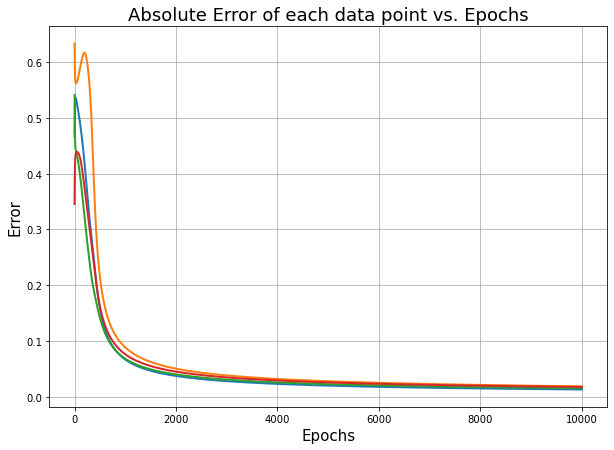

In [ ]:
plt.figure(figsize = (10,7))
plt.title('Absolute Error of each data point vs. Epochs',fontsize=18); plt.grid()
plt.xlabel('Epochs',fontsize=15); plt.ylabel('Error',fontsize=15)
for i in range(4):
    plt.plot(np.abs(Err_mtx[:,i]),lw=2)

print('Hidden Layer Weights: ',weights[-1].T[0])
print('Input Layer Weights:\n',weights[0])

The following code checks if the database data is working and creates an input and output array based on this data. 


In [ ]:
fn = '/content/testdata.nc'
ds = nc.Dataset(fn)

yAxis = [];
xAxis = np.arange(0.25,5.05,0.05)
for i in range(96):
  yAxis.append(ds['energy'][i][0:])

yAxis_array = np.array(yAxis)

fileObject = open("yAxis_array",'wb')
pickle.dump(yAxis_array,fileObject)
fileObject.close() 

NameError: name 'nc' is not defined

[-1.164 -0.679 -0.117] [0.916 1.237 0.908] 0.944 0.081


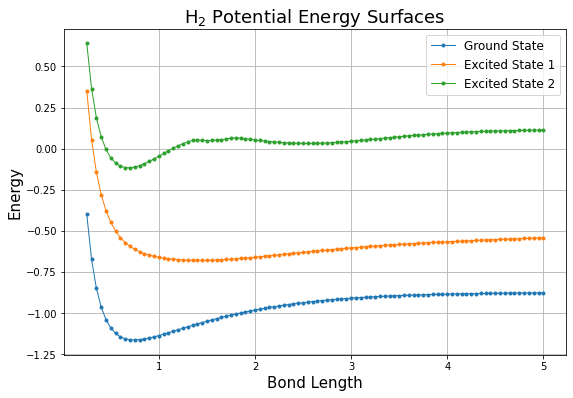

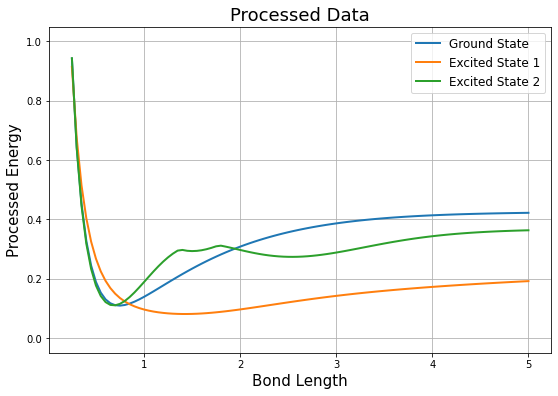

In [2]:
fileObject = open("yAxis_array",'rb')
yAxis_array = pickle.load(fileObject)
fileObject.close()
xAxis = np.arange(0.25,5.05,0.05)

plot_titles = ['Ground State','Excited State 1','Excited State 2','Average']

plt.figure(figsize=(9,6))
plt.title(r'H$_2$ Potential Energy Surfaces',fontsize=18)
plt.ylabel('Energy',fontsize=15); plt.xlabel('Bond Length',fontsize=15)
for i in range(3):
  plt.plot(xAxis,yAxis_array[:,i],label=plot_titles[i],lw=1,marker='.')
plt.legend(fontsize=12); plt.grid()

yAxisMin = np.zeros(3); normal_factor = np.zeros(3)
for i in range(3):
  yAxisMin[i] = np.min(yAxis_array[:,i])
  normal_factor[i] = (np.max(yAxis_array[:,i]) - yAxisMin[i]) * 1.2
yAxis_normal = (yAxis_array - yAxisMin + 0.1 ) / normal_factor

input_array_H = np.reshape(xAxis, (-1, 1))
output_array_H = yAxis_normal.copy()

plt.figure(figsize=(9,6))
plt.title('Processed Data',fontsize=18); plt.ylim([-0.05,1.05])
plt.ylabel('Processed Energy',fontsize=15); plt.xlabel('Bond Length',fontsize=15)
for i in range(3):
  plt.plot(xAxis,output_array_H[:,i],label=plot_titles[i],lw=2)
plt.legend(fontsize=12); plt.grid()
print(yAxisMin,normal_factor,'{:.3f} {:.3f}'.format(np.max(output_array_H),np.min(output_array_H)))

Change the shape of the network to fit the training. Run the network and see how well it is performing. To improve performance, consider changing the number of hidden layers, the amount of epochs and the learning rate. Try to find the best parametres to estimate the data.

In [ ]:
Hidden_Layer_Nodes = [4]
Epochs = 30000; Learning_rate = 0.1

Predictions_H, Errors_H, weights_H = batch_learn(input_array_H,output_array_H,Hidden_Layer_Nodes,Epochs,Learning_rate)

Errors_Sum = np.sum(np.abs(Errors_H),axis=1)
print(Errors_Sum[-1])


[0.77  0.578 2.783]


-0.064
0.137
-0.257


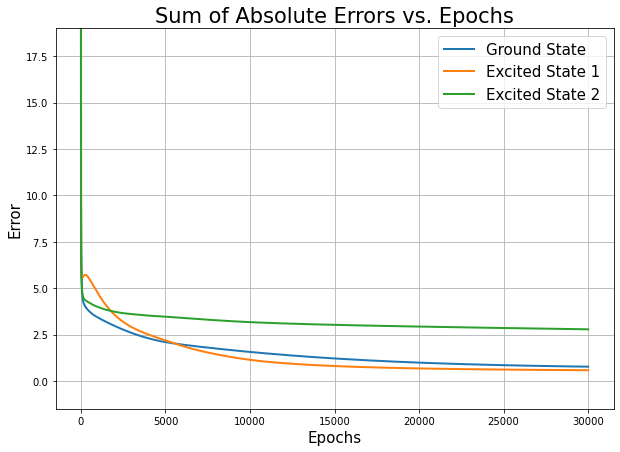

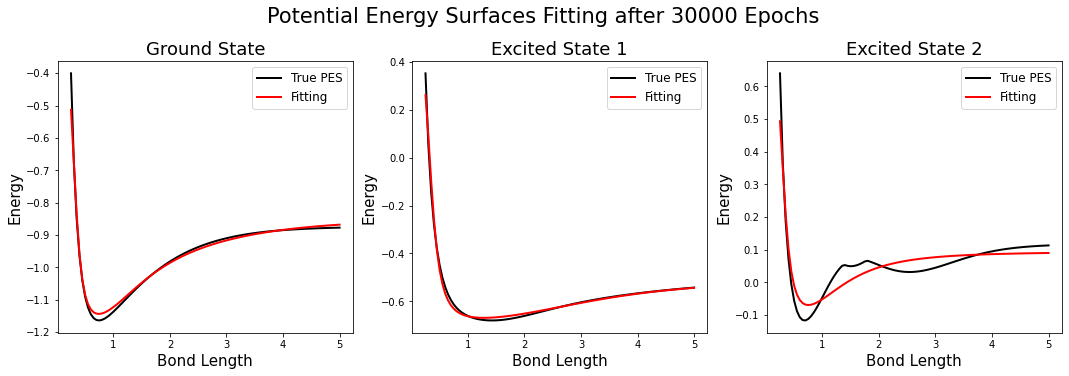

In [ ]:
Errors_Ave = np.mean(np.abs(Errors_H),axis=1)

plt.figure(figsize = (10,7)); plt.grid(); plt.ylim([-1.5,19])
plt.title('Sum of Absolute Errors vs. Epochs',fontsize=21)
plt.xlabel('Epochs',fontsize=15); plt.ylabel('Error',fontsize=15)
#plt.text(10000,13.5,'4 nodes in 1 layer',fontsize=18)

for i in range(3):
  plt.plot(Errors_Sum[:,i],label=plot_titles[i],lw=2)
plt.legend(fontsize=15)

fig,ax = plt.subplots(1,3,figsize = (18,5))
fig.suptitle('Potential Energy Surfaces Fitting after 30000 Epochs',fontsize=21,y=1.03)
Final_prediction = Predictions_H[-1] * normal_factor + yAxisMin - 0.1
for i in range(3):
  ax[i].plot(xAxis,yAxis_array[:,i],label='True PES',lw=2,c='k')
  ax[i].plot(xAxis,Final_prediction[:,i],label='Fitting',lw=2,c='r')
  ax[i].legend(fontsize=12); ax[i].set_title(plot_titles[i],fontsize=18)
  ax[i].set_xlabel('Bond Length',fontsize=15); ax[i].set_ylabel('Energy',fontsize=15)
  print(np.round(np.sum(np.abs(yAxis_array[:,i]-Final_prediction[:,i]))-Errors_Sum[-1,i],3))


In [ ]:
result_list = []
for layers in range(1,9):
  for nodes in range(5,13):
    result = np.zeros(6)
    result[0] = layers; result[1] = nodes
    Hidden_Layer_Nodes = [nodes] * layers

    Predictions_H, Errors_H, weights_H = batch_learn(input_array_H,output_array_H,Hidden_Layer_Nodes,10000,0.1)
    Final_Errors_Sum = np.sum(np.abs(Errors_H[-1]),axis=0)
    result[-1] = np.mean(Final_Errors_Sum); result[2:5] = Final_Errors_Sum

    print(result)
    result_list.append(result)

performance = np.array(result_list)
fileObject = open("Layers_Nodes",'wb')
pickle.dump(performance,fileObject)
fileObject.close()

[1.    5.    0.593 2.106 3.196 1.965]
[1.    6.    0.668 1.608 3.103 1.793]
[1.    7.    0.914 0.883 2.777 1.525]
[1.    8.    0.527 0.659 2.71  1.299]
[1.    9.    1.598 0.879 2.894 1.79 ]
[ 1.    10.     0.484  0.627  2.476  1.196]
[ 1.    11.     6.846  0.709  3.209  3.588]
[ 1.    12.     1.697  0.68   2.636  1.671]
[2.    5.    1.201 1.187 2.394 1.594]
[2.    6.    1.065 0.699 2.297 1.354]
[2.    7.    0.779 0.527 2.253 1.186]
[2.    8.    1.161 0.664 2.418 1.414]
[2.    9.    0.982 0.624 2.241 1.282]
[ 2.    10.     1.008  0.674  1.992  1.225]
[ 2.    11.     0.4    0.502  1.813  0.905]
[ 2.    12.     0.5    0.743  2.269  1.17 ]
[3.    5.    0.969 0.512 2.171 1.217]
[3.    6.    1.073 0.667 2.442 1.394]
[3.    7.    0.808 0.429 2.171 1.136]
[3.    8.    1.015 0.701 1.859 1.191]
[3.    9.    1.058 0.817 1.566 1.147]
[ 3.    10.     0.56   0.429  0.953  0.647]
[ 3.    11.     0.687  0.589  1.053  0.776]
[ 3.    12.     0.321  0.52   1.497  0.78 ]
[4.    5.    1.35  0.63  1.246 1.0

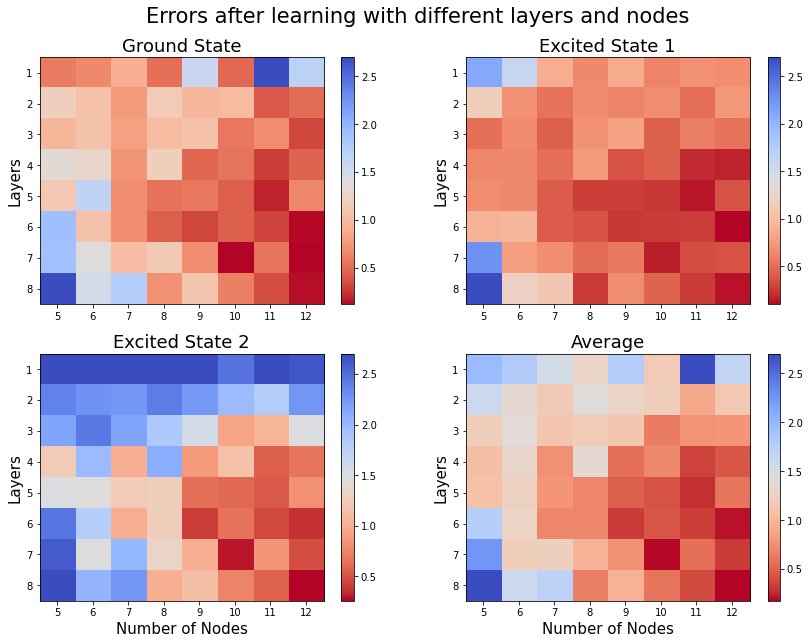

In [ ]:
fileObject = open("Layers_Nodes",'rb')
performance = pickle.load(fileObject)
fileObject.close()

p_im = []
for i in range(4): p_im.append(np.zeros([8,8]))
index = 0
for i in range(8):
  for j in range(8):
    for k  in range(4):
      if performance[index,k+2] <= 2.7: p_im[k][i,j] = performance[index,k+2]
      else: p_im[k][i,j] = 2.7
    index += 1
    
fig,axes = plt.subplots(2,2,figsize=(14,10))
fig.suptitle('Errors after learning with different layers and nodes',y=0.95,fontsize=21)

for i in range(4):
  plt.sca(axes[i//2,i%2]); plt.title(plot_titles[i],fontsize=18)
  plt.imshow(p_im[i],cmap='coolwarm_r',aspect='auto')
  plt.yticks(np.arange(8),np.arange(1,9))
  plt.xticks(np.arange(8),np.arange(5,13))
  plt.ylabel('Layers',fontsize=15)
  plt.colorbar()
for i in range(2):
  plt.sca(axes[1,i])
  plt.xlabel('Number of Nodes',fontsize=15)

In [ ]:
for i in range(4):
  pos = np.where(performance[:,i+2]==np.min(performance[:,i+2]))[0][0]
  print(pos, performance[pos,:])

53 [ 7.    10.     0.116  0.164  0.306  0.195]
47 [ 6.    12.     0.133  0.101  0.382  0.206]
63 [ 8.    12.     0.136  0.132  0.259  0.176]
63 [ 8.    12.     0.136  0.132  0.259  0.176]


In [ ]:
Hidden_Layer_Nodes = [10] * 7
Epochs = 10000; Learning_rate = 0.1

Predictions_H2, Errors_H2, weights_H2 = batch_learn(input_array_H,output_array_H,Hidden_Layer_Nodes,Epochs,Learning_rate)

Errors_Sum_H2 = np.sum(np.abs(Errors_H2),axis=1)
print(Errors_Sum_H2[-1])


[0.283 0.105 0.383]


-0.024
0.025
-0.035


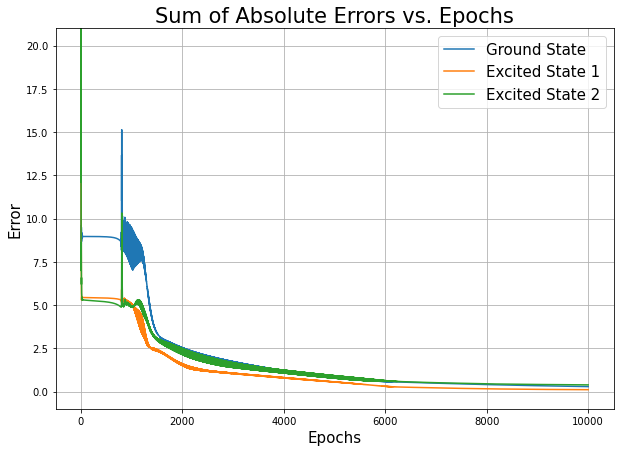

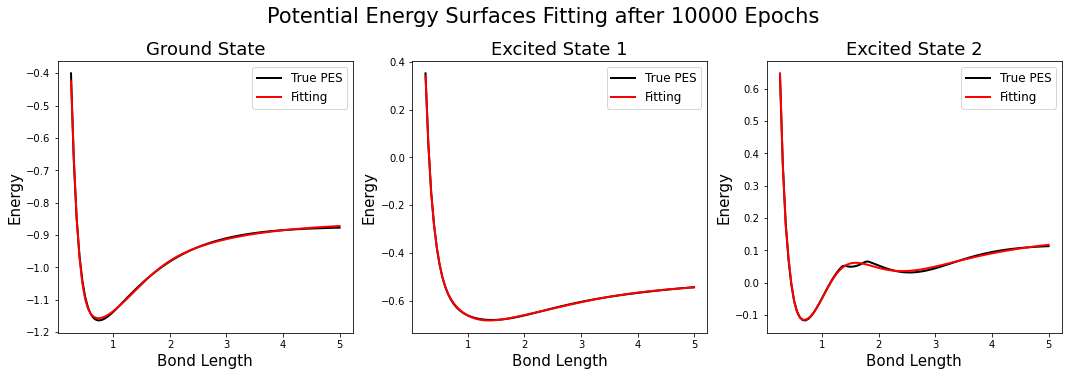

In [ ]:
Errors_Ave = np.mean(np.abs(Errors_H2),axis=1)

plt.figure(figsize = (10,7)); plt.ylim([-1,21]); plt.grid()
plt.title('Sum of Absolute Errors vs. Epochs',fontsize=21)
plt.xlabel('Epochs',fontsize=15); plt.ylabel('Error',fontsize=15)
#plt.text(3100,13.5,'7 layers, 10 nodes each layer',fontsize=18)

for i in range(3):
  plt.plot(Errors_Sum_H2[:,i],label=plot_titles[i])
plt.legend(fontsize=15)

fig,ax = plt.subplots(1,3,figsize = (18,5))
fig.suptitle('Potential Energy Surfaces Fitting after 10000 Epochs',fontsize=21,y=1.03)
Final_prediction = Predictions_H2[-1] * normal_factor + yAxisMin - 0.1
for i in range(3):
  ax[i].plot(xAxis,yAxis_array[:,i],label='True PES',lw=2,c='k')
  ax[i].plot(xAxis,Final_prediction[:,i],label='Fitting',lw=2,c='r')
  ax[i].legend(fontsize=12); ax[i].set_title(plot_titles[i],fontsize=18)
  ax[i].set_xlabel('Bond Length',fontsize=15); ax[i].set_ylabel('Energy',fontsize=15)
  print(np.round(np.sum(np.abs(yAxis_array[:,i]-Final_prediction[:,i]))-Errors_Sum_H2[-1,i],3))


In [ ]:
validation_indices = np.arange(14) * 6 + 11
rest = np.delete(np.arange(96),validation_indices,axis=0)
test_rg = np.random.choice(70,26,replace=False) + 7
test_indices = rest[test_rg]
train_indices = np.delete(rest,test_rg,axis=0)


In [ ]:
#fileObject = open("Test_indices",'wb')
#pickle.dump(test_rg,fileObject)
#fileObject.close()

Text(2.5, 0.42, '56 points')

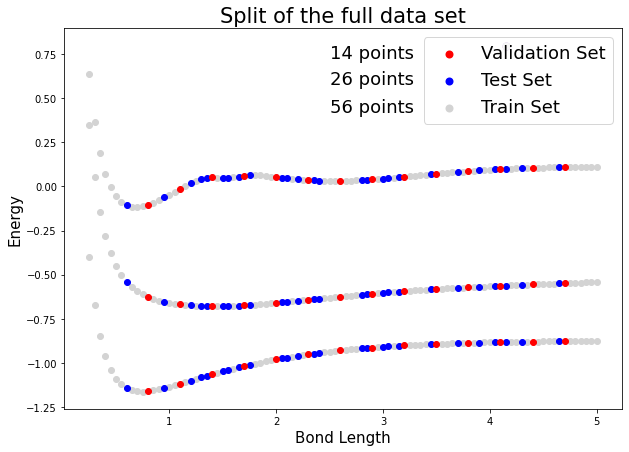

In [3]:
fileObject = open("Test_indices",'rb')
test_rg = pickle.load(fileObject)
fileObject.close()
validation_indices = np.arange(14) * 6 + 11
rest = np.delete(np.arange(96),validation_indices,axis=0)
test_indices = rest[test_rg]
train_indices = np.delete(rest,test_rg,axis=0)

plt.figure(figsize=(10,7))
for i in range(3):
  plt.scatter(xAxis[train_indices],yAxis_array[train_indices,i],lw=1,c='lightgray')
  plt.scatter(xAxis[test_indices],yAxis_array[test_indices,i],lw=1,c='b')
  plt.scatter(xAxis[validation_indices],yAxis_array[validation_indices,i],lw=1,c='r')

plt.scatter(4.15,0.8,c='r',label='Validation Set',lw=2)
plt.scatter(4.15,0.8,c='b',label='Test Set',lw=2)
plt.scatter(4.15,0.8,c='lightgray',label='Train Set',lw=2)

plt.legend(fontsize=18,loc='upper right')
plt.title('Split of the full data set',fontsize=21)
plt.xlabel('Bond Length',fontsize=15)
plt.ylabel('Energy',fontsize=15)
plt.text(2.5,0.73,'14 points',fontsize = 18)
plt.text(2.5,0.58,'26 points',fontsize = 18)
plt.text(2.5,0.42,'56 points',fontsize = 18)
# Training Set (56) & Test Set (26) & Validation Set (14)

In [82]:
train_in = xAxis[train_indices].reshape(train_indices.size,1).copy()
train_out = output_array_H[train_indices,:].copy()
vald_in = xAxis[validation_indices].reshape(validation_indices.size,1).copy()
vald_out = output_array_H[validation_indices,:].copy()
test_in = xAxis[test_indices].reshape(test_indices.size,1).copy()
test_out = output_array_H[test_indices,:].copy()


In [72]:
def val_learn(train_in,train_out,vald_in,vald_out,nodes,epoch,alpha):
    
  weights = []; hidden = [train_in]; w_crr = []
  Err_li = []; ErVld_li = [];  layers = len(nodes);
  nodes.append(train_out.shape[1]); nodes.insert(0,train_in.shape[1])
  epochs = np.ones(3) * epoch; EPOCH = 0
  hidden_vld = [vald_in]; Valid = 0; limit = np.ones(3)*10000

  for i in range(layers+1):
    # initialize Weights
    weights.append(np.random.normal(0,1,(nodes[i],nodes[i+1])))
    hidden.append( np.zeros([train_in.shape[0],nodes[i+1]]) )
    hidden_vld.append(np.zeros([vald_in.shape[0],nodes[i+1]]))
  
  while EPOCH < epoch and Valid < 3:
    EPOCH += 1
    # Forward Propagation
    for i in range(layers+1):
      hidden[i+1] = sig( hidden[i] @ weights[i] )
      hidden_vld[i+1] = sig( hidden_vld[i] @ weights[i] )
    err = hidden[-1] - train_out
    err_vld = hidden_vld[-1] - vald_out
    Err_li.append(err); ErVld_li.append(err_vld)
    # Back Propagation
    for i in range(layers+1):
      Delta = err * dsig(hidden[-1-i])
      w_crr.insert(0,hidden[-2-i].T @ Delta * alpha)
      err = Delta @ weights[-1-i].T
    for i in range(layers+1): weights[i] -= w_crr[i]
    # Validation
    Sum_Er_V = np.sum(np.abs(err_vld),axis=0); Valid = 0
    for i in range(3):
      if Sum_Er_V[i] <= limit[i]:
        limit[i] = Sum_Er_V[i]
      else:
        if limit[i] < 0.1: Valid += 1
        epochs[i] = EPOCH

  return np.array(Err_li),np.array(ErVld_li),weights,epochs

def test_forward(test_in,test_out,weights,nodes):

  hidden = [test_in]; layers = len(weights);
  nodes.append(test_out.shape[1]); nodes.insert(0,test_in.shape[1])
  for i in range(layers): hidden.append(np.zeros([test_in.shape[0],nodes[i+1]]))
  for i in range(layers): hidden[i+1] = sig( hidden[i] @ weights[i] )
  err = hidden[-1] - test_out
  return np.sum(np.abs(err),axis=0)

In [73]:
result_list = []; epoch = 20000; alpha = 0.1
for layers in range(1,9):
  for nodes in range(5,13):
    result = np.zeros(14)
    result[0] = layers; result[1] = nodes
    Hidden_Layer_Nodes = [nodes] * layers

    Err_Train, Errors_V, weights_H, E_HV = val_learn(train_in,train_out,vald_in,vald_out,Hidden_Layer_Nodes,epoch,alpha)
    Sum_Err_Train = np.sum(np.abs(Err_Train[-1]),axis=0)
    Sum_Err_Vld = np.sum(np.abs(Errors_V[-1]),axis=0)
    Sum_Err_Test = test_forward(test_in,test_out,weights_H,Hidden_Layer_Nodes)
    result[2:5] = Sum_Err_Train; result[5] = np.mean(Sum_Err_Train)
    result[6:9] = Sum_Err_Vld; result[9] = np.mean(Sum_Err_Vld)
    result[10:13] = Sum_Err_Test; result[13] = np.mean(Sum_Err_Test)

    print(result,E_HV)
    result_list.append(result)

performance = np.array(result_list)
fileObject = open("V_Layers_Nodes",'wb')
pickle.dump(performance,fileObject)
fileObject.close()

[1.    5.    0.572 0.61  1.479 0.887 0.102 0.116 0.377 0.198 0.172 0.26
 0.797 0.41 ] [20000. 15256. 20000.]
[1.    6.    0.598 0.604 1.434 0.879 0.117 0.119 0.375 0.204 0.198 0.265
 0.776 0.413] [20000. 20000. 17210.]
[1.    7.    0.544 0.485 1.412 0.814 0.1   0.082 0.369 0.184 0.163 0.185
 0.765 0.371] [    4.  9612. 20000.]
[1.    8.    0.323 0.413 1.335 0.691 0.044 0.067 0.337 0.149 0.082 0.153
 0.703 0.312] [  174.  9604. 17867.]
[1.    9.    0.324 0.504 1.284 0.704 0.044 0.099 0.337 0.16  0.068 0.232
 0.698 0.333] [20000. 13423. 13628.]
[ 1.    10.     0.552  0.526  1.302  0.794  0.113  0.103  0.349  0.188
  0.181  0.226  0.72   0.376] [20000. 20000. 20000.]
[ 1.    11.     0.436  0.477  1.323  0.745  0.071  0.089  0.354  0.171
  0.129  0.206  0.735  0.357] [20000.  3883. 20000.]
[ 1.    12.     0.347  0.506  1.06   0.638  0.047  0.095  0.285  0.142
  0.07   0.217  0.589  0.292] [20000.  8454.  8152.]
[2.    5.    0.696 0.503 1.186 0.795 0.134 0.115 0.335 0.195 0.281 0.278
 0.694

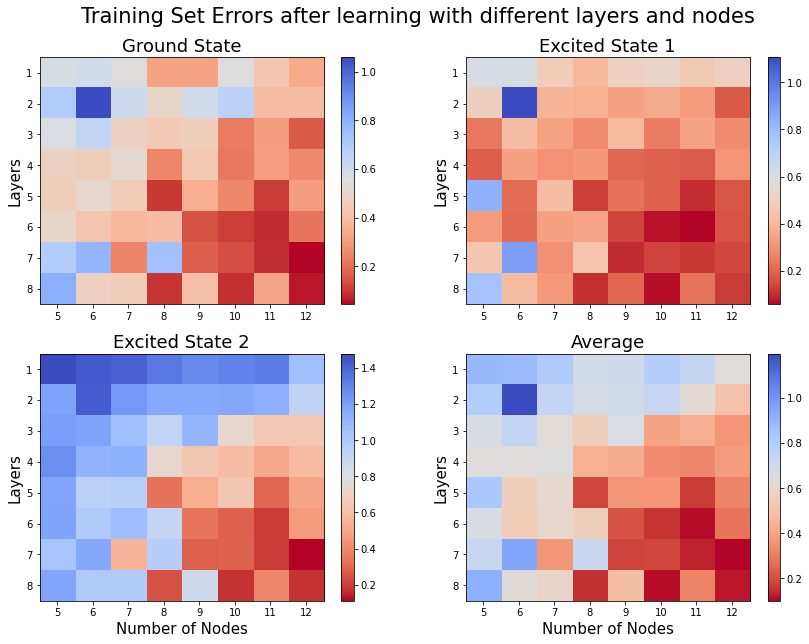

In [77]:
performance_1 = performance[:,2:6].copy()
p_im = []
for i in range(4): p_im.append(np.zeros([8,8]))
index = 0
for i in range(8):
  for j in range(8):
    for k  in range(4):
      if performance_1[index,k] <= 2.7: p_im[k][i,j] = performance_1[index,k]
      else: p_im[k][i,j] = 2.7
    index += 1
    
fig,axes = plt.subplots(2,2,figsize=(14,10))
fig.suptitle('Training Set Errors after learning with different layers and nodes',y=0.95,fontsize=21)

for i in range(4):
  plt.sca(axes[i//2,i%2]); plt.title(plot_titles[i],fontsize=18)
  plt.imshow(p_im[i],cmap='coolwarm_r',aspect='auto')
  plt.yticks(np.arange(8),np.arange(1,9))
  plt.xticks(np.arange(8),np.arange(5,13))
  plt.ylabel('Layers',fontsize=15)
  plt.colorbar()
for i in range(2):
  plt.sca(axes[1,i])
  plt.xlabel('Number of Nodes',fontsize=15)

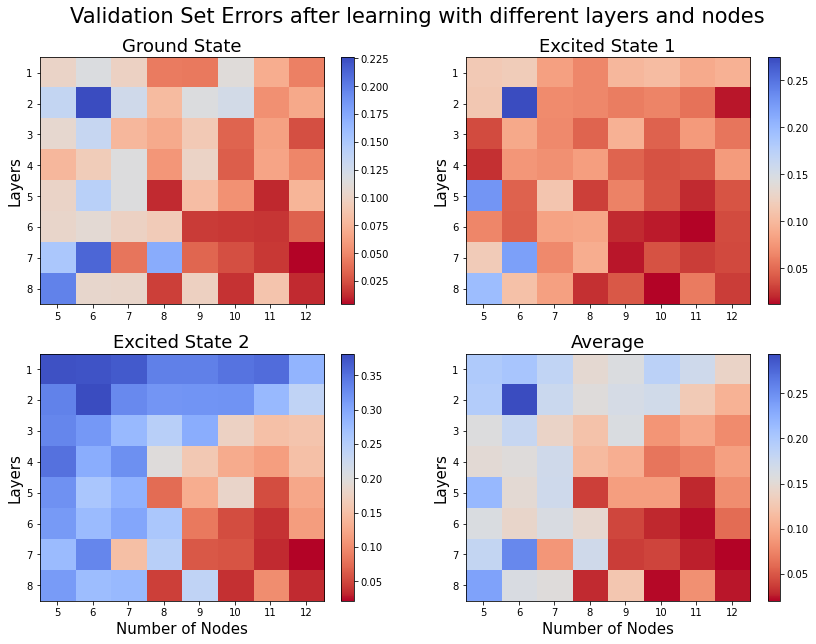

In [80]:
performance_2 = performance[:,6:10].copy()
p_im = []
for i in range(4): p_im.append(np.zeros([8,8]))
index = 0
for i in range(8):
  for j in range(8):
    for k  in range(4):
      if performance_2[index,k] <= 2.7: p_im[k][i,j] = performance_2[index,k]
      else: p_im[k][i,j] = 2.7
    index += 1
    
fig,axes = plt.subplots(2,2,figsize=(14,10))
fig.suptitle('Validation Set Errors after learning with different layers and nodes',y=0.95,fontsize=21)

for i in range(4):
  plt.sca(axes[i//2,i%2]); plt.title(plot_titles[i],fontsize=18)
  plt.imshow(p_im[i],cmap='coolwarm_r',aspect='auto')
  plt.yticks(np.arange(8),np.arange(1,9))
  plt.xticks(np.arange(8),np.arange(5,13))
  plt.ylabel('Layers',fontsize=15)
  plt.colorbar()
for i in range(2):
  plt.sca(axes[1,i])
  plt.xlabel('Number of Nodes',fontsize=15)

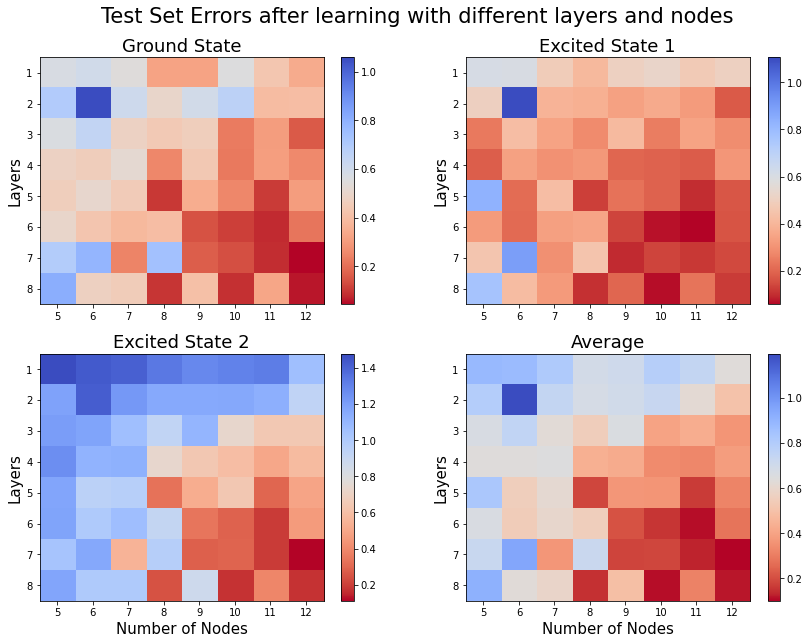

In [81]:
performance_3 = performance[:,11:14].copy()
p_im = []
for i in range(4): p_im.append(np.zeros([8,8]))
index = 0
for i in range(8):
  for j in range(8):
    for k  in range(4):
      if performance_1[index,k] <= 2.7: p_im[k][i,j] = performance_1[index,k]
      else: p_im[k][i,j] = 2.7
    index += 1
    
fig,axes = plt.subplots(2,2,figsize=(14,10))
fig.suptitle('Test Set Errors after learning with different layers and nodes',y=0.95,fontsize=21)

for i in range(4):
  plt.sca(axes[i//2,i%2]); plt.title(plot_titles[i],fontsize=18)
  plt.imshow(p_im[i],cmap='coolwarm_r',aspect='auto')
  plt.yticks(np.arange(8),np.arange(1,9))
  plt.xticks(np.arange(8),np.arange(5,13))
  plt.ylabel('Layers',fontsize=15)
  plt.colorbar()
for i in range(2):
  plt.sca(axes[1,i])
  plt.xlabel('Number of Nodes',fontsize=15)

(32, 1) (32, 3)


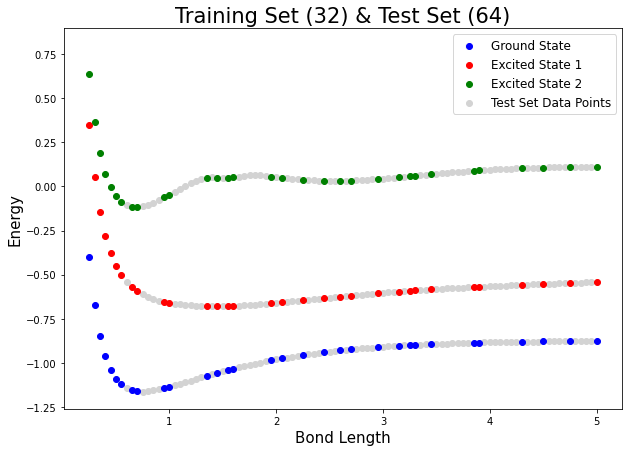

In [ ]:
fileObject = open("Test_indices",'rb')
test_indices = pickle.load(fileObject)
fileObject.close()

train_indices = np.delete(np.arange(96),test_indices,axis=0)
Train_set_in = np.delete(input_array_H,test_indices,axis=0)
Train_set_out = np.delete(output_array_H,test_indices,axis=0)
Test_set_in = input_array_H[test_indices].copy()
Test_set_out = output_array_H[test_indices,:].copy()
Test_set_ans = yAxis_array[test_indices,:].copy()

cl = ['b','r','g']
plt.figure(figsize=(10,7))
for i in range(3):  
  plt.scatter(Test_set_in,yAxis_array[test_indices,i],c='lightgray')
  plt.scatter(Train_set_in,yAxis_array[train_indices,i],lw=1,label=plot_titles[i],c=cl[i])
plt.scatter(3.8,0.8,c='lightgray',label='Test Set Data Points')
plt.legend(fontsize=12,loc='upper right')
plt.title('Training Set (32) & Test Set (64)',fontsize=21)
plt.xlabel('Bond Length',fontsize=15)
plt.ylabel('Energy',fontsize=15)
print(Train_set_in.shape,Train_set_out.shape)

In [ ]:
Hidden_Layer_Nodes = [10] * 7
Epochs = 50000; Learning_rate = 0.1

Predictions_T, Errors_T, weights_T = batch_learn(Train_set_in,Train_set_out,Hidden_Layer_Nodes,Epochs,Learning_rate)

Errors_Sum_T = np.sum(np.abs(Errors_T),axis=1)
print(Errors_Sum_T[-1])

[0.07  0.073 0.145]


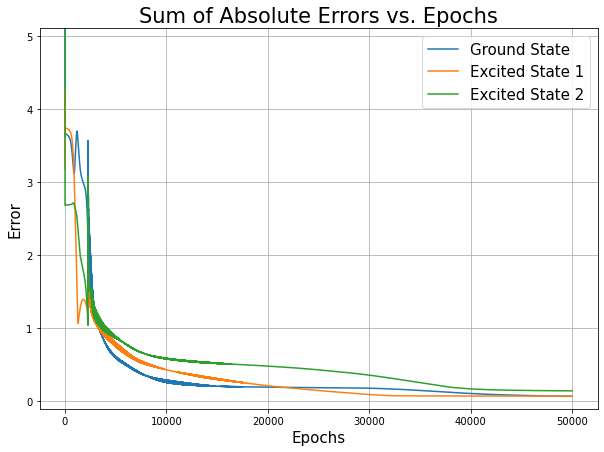

In [ ]:
plt.figure(figsize = (10,7)); plt.grid(); plt.ylim([-0.1,5.1])
plt.title('Sum of Absolute Errors vs. Epochs',fontsize=21)
plt.xlabel('Epochs',fontsize=15); plt.ylabel('Error',fontsize=15)
# plt.text(3100,13.5,'7 layers, 10 nodes each layer',fontsize=18)

for i in range(3):
  plt.plot(Errors_Sum_T[:,i],label=plot_titles[i])
plt.legend(fontsize=15)

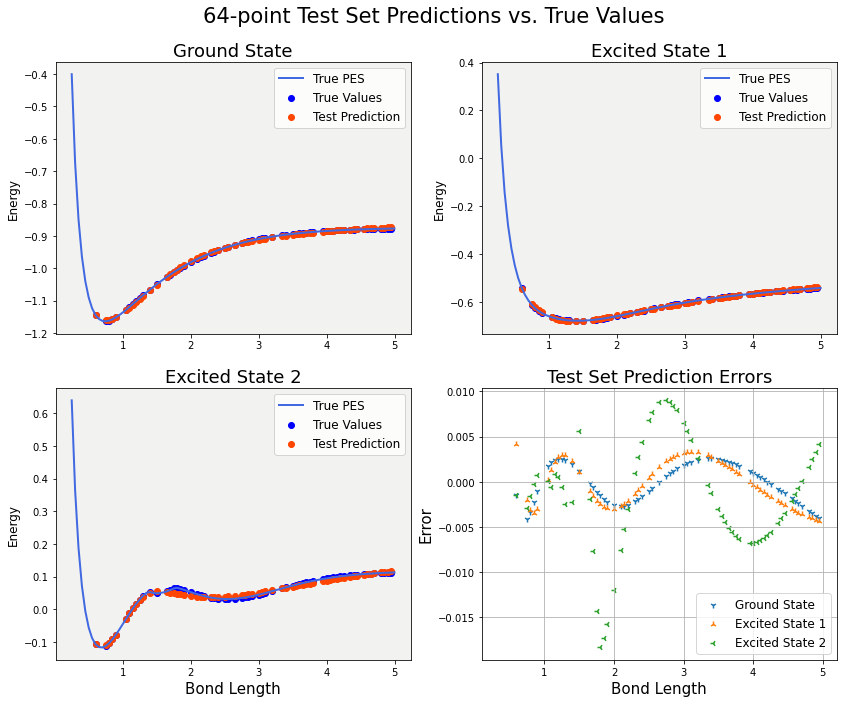

In [ ]:
fig,axes = plt.subplots(2,2,figsize = (14,11))
fig.suptitle('64-point Test Set Predictions vs. True Values',fontsize=21,y=0.95)
Final_prediction_T = Predictions_T[-1] * normal_factor + yAxisMin - 0.1

Test_prediction = Test_set_in.copy()
for i in range(len(weights_T)):
  Test_prediction = sig(Test_prediction @ weights_T[i])
Test_prediction = Test_prediction * normal_factor + yAxisMin - 0.1

for i in range(3):
  plt.sca(axes[i//2,i%2])
  plt.plot(xAxis,yAxis_array[:,i],label='True PES',lw=2,c='royalblue')
  plt.scatter(Test_set_in,Test_set_ans[:,i],label='True Values',lw=1,c='b')
  plt.scatter(Test_set_in,Test_prediction[:,i],c='orangered',label='Test Prediction')
  axes[i//2,i%2].set_facecolor((0.95,0.95,0.94))
  plt.legend(fontsize=12,loc='upper right'); plt.title(plot_titles[i],fontsize=18)
  plt.ylabel('Energy',fontsize=12)

#Test_err = np.abs(Test_prediction) / np.abs(Test_set_ans) * 100 - 100
Test_err = np.abs(Test_prediction) - np.abs(Test_set_ans)

plt.sca(axes[1,1]); plt.grid(); plt.ylabel('Error',fontsize=15)
for i in range(3):
  plt.scatter(Test_set_in,Test_err[:,i],label=plot_titles[i],marker='%d'%(i+1))
plt.title('Test Set Prediction Errors',fontsize=18); #plt.ylim([-125,125])
plt.xlim([0.1,5.2]); plt.legend(loc='lower right',fontsize=12)
for i in range(2): axes[1,i].set_xlabel('Bond Length',fontsize=15)